In [ ]:
# Transfer Learning(전이학습) 을 활용한 고양이와 강아지 분류기   
# - 사전학습된 모델을 활용하여 새로운 작업에 적합하도록 미세조정하는 기법
# - 대규모 데이터셋에서 학습된 모델의 가중치를 초기화에 사용하여 학습 속도 향상 및 성능 개선
# - 특징 추출기로 사용하거나, 일부 레이어만 미세조정할 수 있음

# Transfer Learning(전이학습) 학습 목표
# - 사전학습된 모델을 불러와 새로운 작업에 맞게 조정하는 방법 이해
# - 고양이와 강아지 분류기를 구축하여 이미지 분류 문제 해결
# - PyTorch와 torchvision 라이브러리를 활용한 딥러닝 모델 구현 및 배포
# - Streamlit을 사용하여 간단한 웹 애플리케이션으로 모델 배포

# 모델 설명
# - torchvision.models에서 사전학습된 모델 불러오기
# - 모델의 마지막 레이어를 새로운 작업에 맞게 교체
# - 특징 추출기로 사용할지, 일부 레이어만 미세조정할지 결정 (여기서는 특징 추출기로 사용)

In [2]:
# 1) 라이브러리, GPU 설정
import torch
from torch import nn
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, zipfile, datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('PyTorch Version:', torch.__version__ , "Using device:", device)

PyTorch Version: 2.7.1+cu118 Using device: cuda


In [21]:
# 2) 경로 설정
ROOT_DIR = './data'  # 데이터셋 Root 경로
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'cats_and_dogs_filtered')  # 데이터셋 경로
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')  # 훈련 데이터셋 경로
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')  # 검증 데이터셋 경로
# print(TRAIN_DATA_ROOT_DIR)

MODEL_PATH = './models'  # 모델 저장 경로
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)
MODEL_NAME = 'transfer_learning_model_cats_dogs.pth'  # 모델 파일명
MODEL_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_NAME)  # 모델 저장 전체 경로
print('MODEL_SAVE_PATH:', MODEL_SAVE_PATH)

MODEL_SAVE_PATH: ./models\transfer_learning_model_cats_dogs.pth


In [4]:
# 3) 데이터셋 다운로드
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O ./data/cats_and_dogs_filtered.zip

--2025-10-07 14:40:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.128.10.91, 34.128.10.123, 34.128.9.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.128.10.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: './data/cats_and_dogs_filtered.zip'

     0K .......... .......... .......... .......... ..........  0%  429K 2m36s
    50K .......... .......... .......... .......... ..........  0%  419K 2m38s
   100K .......... .......... .......... .......... ..........  0% 20.2M 1m46s
   150K .......... .......... .......... .......... ..........  0% 14.4M 81s
   200K .......... .......... .......... .......... ..........  0% 9.05M 66s
   250K .......... .......... .......... .......... ..........  0% 73.4M 55s
   300K .......... .......... .......... .......... ..........  0% 22.6M 48s
   350K .......... 

In [5]:
# 4) 데이터셋 경로 존재 여부 확인, 압축 해제
if not os.path.exists(DATA_ROOT_DIR):
    # 압축 해제
    with zipfile.ZipFile(os.path.join(ROOT_DIR, 'cats_and_dogs_filtered.zip'), 'r') as zip_ref:
        zip_ref.extractall(ROOT_DIR)
    print('Data unzip completed.')

In [6]:
# 5) 데이터셋 확인
# train
train_cats_list = os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, 'cats'))  # 훈련용 고양이 이미지 경로
train_dogs_list = os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, 'dogs'))  # 훈련용 강아지 이미지 경로
print('훈련용 고양이 이미지 개수:', len(train_cats_list), '훈련용 강아지 이미지 개수:', len(train_dogs_list))

# validation
validation_cats_list = os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, 'cats'))  # 검증용 고양이 이미지 경로
validation_dogs_list = os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, 'dogs'))  # 검증용 강아지 이미지 경로
print('검증용 고양이 이미지 개수:', len(validation_cats_list), '검증용 강아지 이미지 개수:', len(validation_dogs_list))

훈련용 고양이 이미지 개수: 1000 훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500 검증용 강아지 이미지 개수: 500


In [7]:
# 6) 데이터셋 전처리
# - 전이학습에 사용되는 사전학습모델(pre-trained model)은 일반적으로 224x224 크기의 이미지를 입력으로 사용
# - 따라서 데이터셋의 이미지 크기를 224x224로 변환하고, 정규화(Normalization) 수행
# - 또한 데이터 증강(Data Augmentation) 기법을 사용하여 모델의 일반화 성능 향상
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224x224로 강제 리사이즈
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224x224로 강제 리사이즈
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# 7) 데이터셋 생성, 데이터로더 생성
# - ImageFolder 클래스를 사용하여 이미지 폴더로부터 데이터셋 생성
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_ROOT_DIR, transform=train_transform)  # 훈련 데이터셋
validation_dataset = datasets.ImageFolder(root=VALIDATION_DATA_ROOT_DIR, transform=validation_transform)  # 검증 데이터셋
print('훈련 데이터셋 크기:', len(train_dataset), '검증 데이터셋 크기:', len(validation_dataset))

# 데이터로더 생성
BATCH_SIZE = 32  # 배치 크기
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)  # 훈련 데이터로더
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)  # 검증 데이터로더

훈련 데이터셋 크기: 2000 검증 데이터셋 크기: 1000


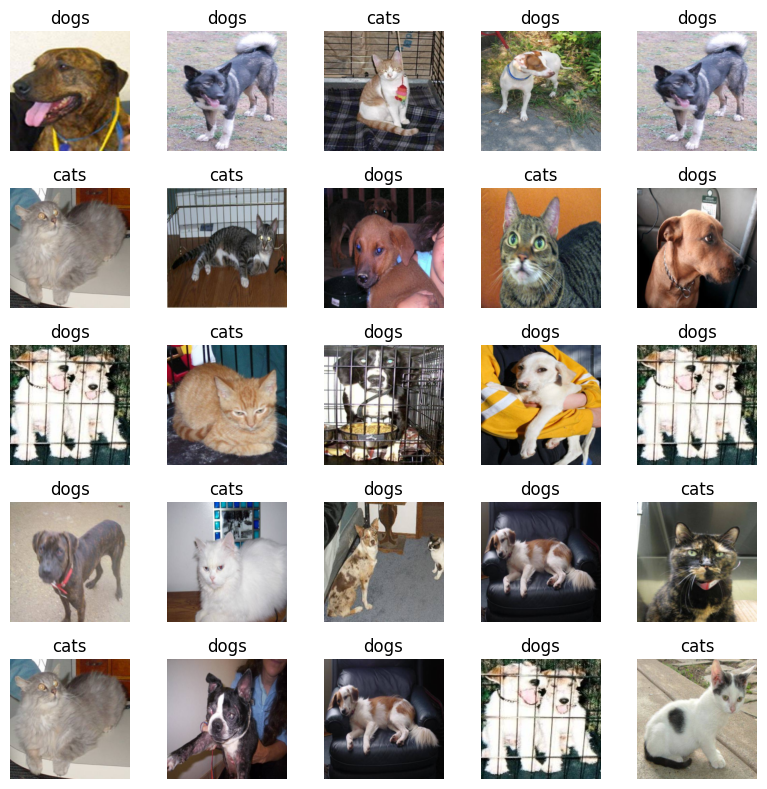

In [9]:
# 8) 이미지 데이터 확인
inputs, labels = next(iter(train_dataloader))  # 배치 단위로 데이터 가져오기

plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(cols * rows):  # 25개만 반복
    sample_idx = torch.randint(len(inputs), size=(1,)).item()  # 배치 내에서 랜덤하게 인덱스 선택
    img, label = inputs[sample_idx], labels[sample_idx].item()  # 이미지와 라벨 가져오기
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # 정규화 역변환
    img = torch.clamp(img, 0, 1)  # 값의 범위 제한  # 0~1 사이로 클램핑

    plt.subplot(rows, cols, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # 이미지 출력
    plt.title(train_dataset.classes[label])  # 클래스명 출력
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# 9) Transfer Learning(전이학습) 모델 생성
# 분류기(heads 부분)만 파인튜닝(fine-tuning)
# feature_extractor = True로 설정되어 있어서, Vision Transformer의 특징 추출기(기존 레이어) 파라미터는 requires_grad = False로 동결된다.
# 분류기(base_model.heads) 부분만 새로 정의되어, 이 부분만 학습이 진행된다. 기존 backbone(특징 추출기)는 고정하고, 분류기만 새롭게 학습하는 전형적인 transfer learning 방식
# feature_extractor = False로 설정하면 모든 레이어(특징 추출기 + 분류기)가 학습(파인튜닝) 대상이 된다.
class TransferLearningModel(nn.Module):
    def __init__(self, base_model, feature_extractor=True, num_classes=2):
        super().__init__()
        
        if (feature_extractor):
            for param in base_model.parameters():
                param.requires_grad = False  # 특징 추출기 부분의 가중치 동결
        
        # vision transformer 모델의 특징 추출기 부분과 분류기 부분 분리
        in_features = base_model.heads.head.in_features  # 분류기 부분의 입력 특징 수

        base_model.heads = torch.nn.Sequential(
            torch.nn.Linear(in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),  # 드롭아웃 추가 # 오버피팅 방지
            torch.nn.Linear(128, num_classes)
        )
        self.model = base_model

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
# 10) 하이퍼파라미터 설정

# 사전학습모델 불러오기
# - torchvision 라이브러리에서 제공하는 사전학습모델(pre-trained model) 중 ViT(Vision Transformer) 모델을 사용
base_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
print(base_model)

feature_extractor = True  # 특징 추출기 부분의 가중치 동결 여부
num_classes = 2  # 고양이와 강아지 2개 부류
model = TransferLearningModel(base_model, feature_extractor, num_classes).to(device)
print(model)

# 손실함수, 최적화기 설정
loss_function = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제에 적합한 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam 최적화기
# Tip: optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)로 동결된 파라미터를 제외하고 최적화할 수 있음.


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [12]:
# 11) 모델 학습 함수
def model_train(dataloader, model, loss_function, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동

        optimizer.zero_grad()  # 기울기 초기화

        outputs = model(inputs)  # 모델에 입력 데이터 전달하여 출력 계산
        loss = loss_function(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파(미분 연산) 수행
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item() * inputs.size(0)  # 배치 손실 누적
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 계산
        correct_predictions += (predicted == labels).sum().item()  # 정확한 예측 개수 누적
        total_predictions += labels.size(0)  # 전체 예측 개수 누적

    epoch_loss = running_loss / len(dataloader.dataset)  # 에포크 손실 계산
    epoch_accuracy = correct_predictions / total_predictions  # 에포크 정확도 계산

    return epoch_loss, epoch_accuracy

In [13]:
# 12) 모델 검증 함수
def model_evaluate(dataloader, model, loss_function, device):
    model.eval()  # 모델을 평가 모드로 설정
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동

            outputs = model(inputs)  # 모델에 입력 데이터 전달하여 출력 계산
            loss = loss_function(outputs, labels)  # 손실 계산

            running_loss += loss.item() * inputs.size(0)  # 배치 손실 누적
            _, predicted = torch.max(outputs, 1)  # 예측 클래스 계산
            correct_predictions += (predicted == labels).sum().item()  # 정확한 예측 개수 누적
            total_predictions += labels.size(0)  # 전체 예측 개수 누적

    epoch_loss = running_loss / len(dataloader.dataset)  # 에포크 손실 계산
    epoch_accuracy = correct_predictions / total_predictions  # 에포크 정확도 계산

    return epoch_loss, epoch_accuracy

In [ ]:
# 13) 전체 검증 데이터셋 추론 및 분석
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def model_all_test(dataloader, model, loss_function):
    model.eval()

    all_preds = []
    all_labels = []
    all_losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_losses.append(loss.item())

    # 정확도 계산
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    avg_loss = np.mean(all_losses)
    print(f'Validation Accuracy (전체): {accuracy*100:.2f}%, Average Loss: {avg_loss:.4f}')

    # 혼동행렬 및 분류 리포트
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:\n', cm)
    print('Classification Report:\n', classification_report(all_labels, all_preds, target_names=dataloader.dataset.classes))

    # 오답 샘플 시각화 (옵션)
    wrong_indices = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]
    plt.figure(figsize=(10, 8))
    for i in range(min(10, len(wrong_indices))):
        idx = wrong_indices[i] # 오답 인덱스
        img, true_label, pred_label = dataloader.dataset[idx][0], all_labels[idx], all_preds[idx] # 이미지, 실제 라벨, 예측 라벨
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 정규화 역변환
        img = torch.clamp(img, 0, 1) # 값의 범위 제한
        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # 이미지 출력, 채널 위치 변경 (채널, 높이, 너비) -> (높이, 너비, 채널)
        plt.title(f"T:{dataloader.dataset.classes[true_label]}\nP:{dataloader.dataset.classes[pred_label]}") # 실제 라벨, 예측 라벨
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 14) 모델 학습 및 검증
num_epochs = 20  # 에포크 수
best_validation_accuracy = 0.0  # 최고 검증 정확도 초기화
start_time = datetime.datetime.now()  # 학습 시작 시간 기록
print('Training started at:', start_time.strftime('%Y-%m-%d %H:%M:%S'))

train_loss_list = []
train_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = model_train(train_dataloader, model, loss_function, optimizer, device)  # 모델 학습
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    validation_loss, validation_accuracy = model_evaluate(validation_dataloader, model, loss_function, device)  # 모델 검증
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')

    # 최고 검증 정확도 갱신 시 모델 저장
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f'Model saved with Validation Accuracy: {best_validation_accuracy:.4f}')

end_time = datetime.datetime.now()  # 학습 종료 시간 기록
print('Training ended at:', end_time.strftime('%Y-%m-%d %H:%M:%S'))
print('Total training time:', str(end_time - start_time))

Training started at: 2025-10-07 14:41:09
Epoch 1/20, Train Loss: 0.4392, Train Accuracy: 0.8370, Validation Loss: 0.2259, Validation Accuracy: 0.9870
Model saved with Validation Accuracy: 0.9870
Epoch 2/20, Train Loss: 0.1436, Train Accuracy: 0.9900, Validation Loss: 0.0949, Validation Accuracy: 0.9930
Model saved with Validation Accuracy: 0.9930
Epoch 3/20, Train Loss: 0.0689, Train Accuracy: 0.9935, Validation Loss: 0.0571, Validation Accuracy: 0.9940
Model saved with Validation Accuracy: 0.9940
Epoch 4/20, Train Loss: 0.0433, Train Accuracy: 0.9965, Validation Loss: 0.0411, Validation Accuracy: 0.9950
Model saved with Validation Accuracy: 0.9950
Epoch 5/20, Train Loss: 0.0303, Train Accuracy: 0.9980, Validation Loss: 0.0325, Validation Accuracy: 0.9950
Epoch 6/20, Train Loss: 0.0228, Train Accuracy: 0.9975, Validation Loss: 0.0275, Validation Accuracy: 0.9960
Model saved with Validation Accuracy: 0.9960
Epoch 7/20, Train Loss: 0.0184, Train Accuracy: 0.9980, Validation Loss: 0.0239,

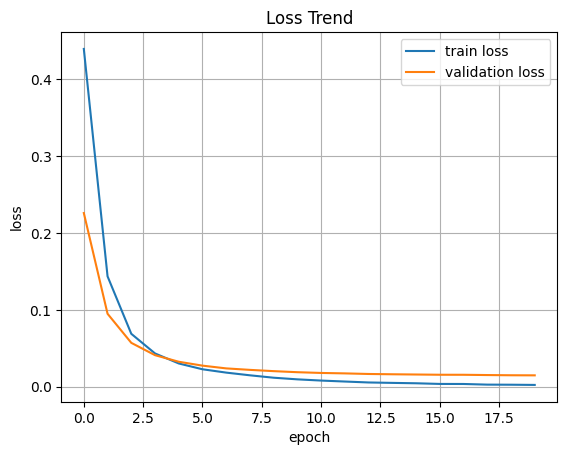

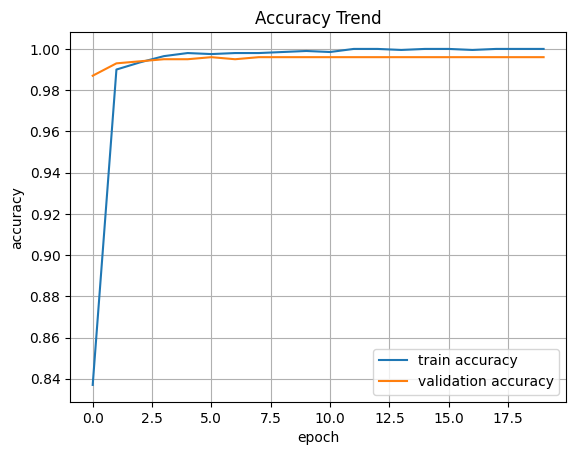

In [ ]:
# 15) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(validation_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(validation_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

Validation Accuracy (전체): 99.60%, Average Loss: 0.0145
Confusion Matrix:
 [[497   3]
 [  1 499]]
Classification Report:
               precision    recall  f1-score   support

        cats       1.00      0.99      1.00       500
        dogs       0.99      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



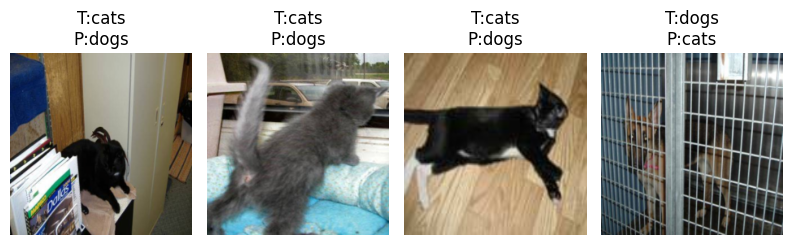

In [29]:
# 16) 전체 테스트셋 추론 및 오답 시각화
model_all_test(dataloader=validation_dataloader, model=model, loss_function=loss_function)

In [30]:
# 17) 모델 저장
os.makedirs(MODEL_PATH, exist_ok=True)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f'Model saved at: {MODEL_SAVE_PATH}')

Model saved at: ./models\transfer_learning_model_cats_dogs.pth


In [31]:
# 18) 모델 추론 및 예측값 추출
# 저장된 모델 불러오기
model = TransferLearningModel(
    models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT),
    feature_extractor=True,
    num_classes=2
).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

TransferLearningModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (